In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
import os

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

from chesswinnerprediction.baseline.utils import get_x_and_y, get_class_weights, print_combined_report, show_feature_importance
from chesswinnerprediction.constants import PROCESSED_FOLDER_PATH

In [3]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [4]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [5]:
BASELINE_COLUMNS = [
    "Result",
    "EloDiff",
    "WhiteElo",
    "BlackElo",
    "Event",
    "BaseTime",
    "IncrementTime",
    "ZeroIncrementTime"
]

columns_to_scale = ["WhiteElo", "BlackElo", "EloDiff", "BaseTime", "IncrementTime"]

In [6]:
def transform_and_scale_df(df, scaler: StandardScaler, fit_scale=True):
    X = df[BASELINE_COLUMNS].copy()
    X = pd.get_dummies(X, columns=["Event"], dtype=np.int8, prefix="", prefix_sep="")
    if fit_scale:
        X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
    else:
        X[columns_to_scale] = scaler.transform(X[columns_to_scale])
    return X

In [7]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scale=False)

In [8]:
class_weights = get_class_weights(train_df["Result"], verbose=True)

Class weights:
	1-0: 0.6718789964523187
	0-1: 0.6971858059373535
	1/2-1/2: 12.936795431862432


In [9]:
x_train_data, y_train = get_x_and_y(train_data, predict_draws=True)
x_valid_data, y_valid = get_x_and_y(valid_data, predict_draws=True)

In [10]:
# r_model = LogisticRegression(
#     tol=2e-4,
#     class_weight=class_weights,
#     max_iter=500,
#     penalty="l2",
#     solver="saga"
# )

In [11]:
# r_model.fit(x_train_data, y_train)

In [86]:
def my_score(model, x_data, y_data):
    y_pred = model.predict(x_data)    
    weighted_f1 = f1_score(y_data, y_pred, average="weighted")
    return weighted_f1

In [162]:
param_grid = {
    "n_estimators": [15, 20, 30, 40],
    "max_depth": [8, 9, 10, 11, 12],
    "max_features": [len(x_train_data.columns), "sqrt", 0.5],
    "min_samples_split": [3, 5, 10, 15, 20],
    "min_samples_leaf": [2, 3, 5, 8],
    "min_impurity_decrease": [0.0, 0.0001, 0.0002, 0.0005],
}

forest_clf = RandomForestClassifier(class_weight=class_weights, verbose=0, n_jobs=-1)


random_search = RandomizedSearchCV(
    estimator=forest_clf, 
    param_distributions=param_grid, 
    n_iter=8,
    cv=2, 
    verbose=4, 
    random_state=42, 
    scoring="recall_macro", 
    return_train_score=True,
   # n_jobs=-1
)

In [163]:
# Fit the random search model
random_search.fit(x_train_data, y_train)

# Print the best parameters and best estimator
print(f"Best Parameters: {random_search.best_params_}")
best_forest_clf = random_search.best_estimator_
print(f"Best Estimator: {best_forest_clf}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END max_depth=8, max_features=0.5, min_impurity_decrease=0.0002, min_samples_leaf=8, min_samples_split=3, n_estimators=15;, score=(train=0.470, test=0.462) total time=   4.7s
[CV 2/2] END max_depth=8, max_features=0.5, min_impurity_decrease=0.0002, min_samples_leaf=8, min_samples_split=3, n_estimators=15;, score=(train=0.468, test=0.467) total time=   4.6s
[CV 1/2] END max_depth=11, max_features=0.5, min_impurity_decrease=0.0005, min_samples_leaf=2, min_samples_split=15, n_estimators=15;, score=(train=0.465, test=0.458) total time=   4.6s
[CV 2/2] END max_depth=11, max_features=0.5, min_impurity_decrease=0.0005, min_samples_leaf=2, min_samples_split=15, n_estimators=15;, score=(train=0.463, test=0.464) total time=   4.4s
[CV 1/2] END max_depth=11, max_features=auto, min_impurity_decrease=0.0002, min_samples_leaf=5, min_samples_split=15, n_estimators=15;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/2] END max_

/home/tikhon/PycharmProjects/ChessWinnerPrediction/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 16.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tikhon/PycharmProjects/ChessWinnerPrediction/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tikhon/PycharmProjects/ChessWinnerPrediction/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/tikhon/PycharmProjects/ChessWinnerPrediction/

Best Parameters: {'n_estimators': 15, 'min_samples_split': 3, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.0002, 'max_features': 0.5, 'max_depth': 8}
Best Estimator: RandomForestClassifier(class_weight={'0-1': np.float64(0.6971858059373535),
                                     '1-0': np.float64(0.6718789964523187),
                                     '1/2-1/2': np.float64(12.936795431862432)},
                       max_depth=8, max_features=0.5,
                       min_impurity_decrease=0.0002, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=15, n_jobs=-1)


In [164]:
print(f"Best Score: {random_search.best_score_}")

Best Score: 0.46481233479194184


In [165]:
best_forest_clf.fit(x_train_data, y_train)

RandomForestClassifier(class_weight={'0-1': np.float64(0.6971858059373535),
                                     '1-0': np.float64(0.6718789964523187),
                                     '1/2-1/2': np.float64(12.936795431862432)},
                       max_depth=8, max_features=0.5,
                       min_impurity_decrease=0.0002, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=15, n_jobs=-1)

In [166]:
print_combined_report(best_forest_clf, x_train_data, x_valid_data, y_train, y_valid)

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.61      0.41      0.49    378036              0.61      0.40      0.49     45521
         1-0       0.61      0.43      0.50    392275              0.61      0.43      0.51     47220
     1/2-1/2       0.04      0.57      0.08     20373              0.05      0.57      0.08      2522
    accuracy                           0.42    790684                                  0.42     95263
   macro avg       0.42      0.47      0.36    790684              0.42      0.47      0.36     95263
weighted avg       0.59      0.42      0.48    790684              0.59      0.42      0.49     95263
       


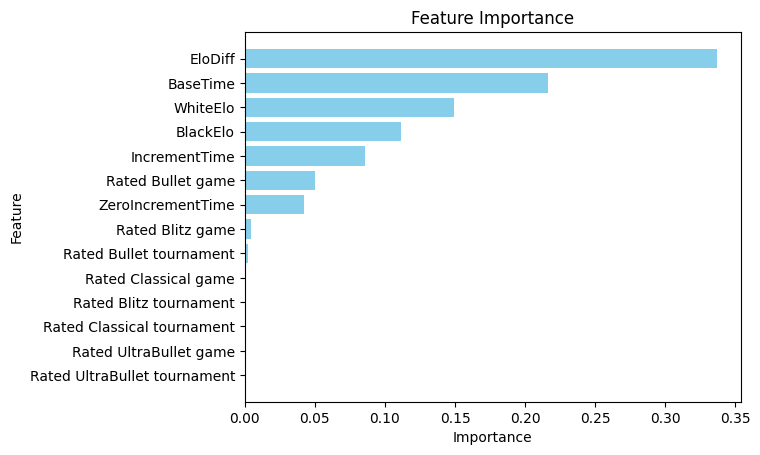

In [167]:
show_feature_importance(best_forest_clf, best_forest_clf.feature_importances_)